In [25]:
import pickle
from sklearn import metrics
import numpy as np
import sklearn.datasets
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import *
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import model_entropy
import model_huber
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os

In [2]:
with open('word-list.p', 'rb') as fopen:
    vocab = pickle.load(fopen)
with open('vector.p', 'rb') as fopen:
    vectors = pickle.load(fopen)
with open('dataset.p', 'rb') as fopen:
    df = pickle.load(fopen)
label = ['negative', 'positive']

In [3]:
tfidf = TfidfVectorizer().fit(df[:,1])
X = tfidf.transform(df[:,1])

In [4]:
from sklearn.cross_validation import train_test_split
train_text, test_text,train_X, test_X, train_Y, test_Y = train_test_split(df[:,1],X, df[:, 0].astype('float').astype('int'), test_size = 0.2)

In [5]:
mod_huber = SGDClassifier(loss = 'modified_huber', 
                                  penalty = 'l2', alpha = 1e-3, 
                                  n_iter = 30).fit(train_X, train_Y)
predicted = mod_huber.predict(test_X)
print('accuracy validation set: ', np.mean(predicted == test_Y))
print(metrics.classification_report(test_Y, predicted, target_names = label))

accuracy validation set:  0.589783281734
             precision    recall  f1-score   support

   negative       0.58      0.63      0.60      1281
   positive       0.60      0.55      0.58      1303

avg / total       0.59      0.59      0.59      2584



/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [6]:
bayes_multinomial = MultinomialNB().fit(train_X, train_Y)
predicted = bayes_multinomial.predict(test_X)
print('accuracy validation set: ', np.mean(predicted == test_Y))
print(metrics.classification_report(test_Y, predicted, target_names = label))

accuracy validation set:  0.585526315789
             precision    recall  f1-score   support

   negative       0.58      0.60      0.59      1281
   positive       0.59      0.57      0.58      1303

avg / total       0.59      0.59      0.59      2584



In [7]:
gb = GradientBoostingClassifier(learning_rate=0.03, n_estimators=200,max_depth=10)
gb.fit(train_X, train_Y)
predicted = gb.predict(test_X)
print('accuracy validation set: ', np.mean(predicted == test_Y))
print(metrics.classification_report(test_Y, predicted, target_names = label))

accuracy validation set:  0.582043343653
             precision    recall  f1-score   support

   negative       0.56      0.71      0.63      1281
   positive       0.62      0.46      0.52      1303

avg / total       0.59      0.58      0.58      2584



In [11]:
ada = AdaBoostClassifier(learning_rate=0.03, n_estimators=200)
ada.fit(train_X, train_Y)
predicted = ada.predict(test_X)
print('accuracy validation set: ', np.mean(predicted == test_Y))
print(metrics.classification_report(test_Y, predicted, target_names = label))

accuracy validation set:  0.540634674923
             precision    recall  f1-score   support

   negative       0.52      0.90      0.66      1281
   positive       0.65      0.19      0.30      1303

avg / total       0.59      0.54      0.48      2584



## global variables for RNN models

In [8]:
maxlen = 40
num_layers = 3
size_layer = 256
learning_rate = 0.0001
batch = 128
dimension = vectors.shape[1]

In [16]:
def train_rnn_early_stopping(sess, model, checkpoint_name, saver):
    EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 10, 0, 0, 0
    while True:
        lasttime = time.time()
        if CURRENT_CHECKPOINT == EARLY_STOPPING:
            print('break epoch:', EPOCH)
            break
        train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
        for i in range(0, (train_text.shape[0] // batch) * batch, batch):
            batch_x = np.zeros((batch, maxlen, dimension))
            batch_y = np.zeros((batch, len(label)))
            for k in range(batch):
                tokens = train_text[i + k].split()[:maxlen]
                for no, text in enumerate(tokens[::-1]):
                    try:
                        batch_x[k, -1 - no, :] += vectors[vocab.index(text), :]
                    except Exception as e:
                        print(e)
                        continue
                batch_y[k, int(train_Y[i + k])] = 1.0
            loss, _ = sess.run([model.cost, model.optimizer], 
                               feed_dict = {model.X : batch_x, model.Y : batch_y})
            train_loss += loss
            train_acc += sess.run(model.accuracy, feed_dict = {model.X : batch_x, model.Y : batch_y})
        
        for i in range(0, (test_text.shape[0] // batch) * batch, batch):
            batch_x = np.zeros((batch, maxlen, dimension))
            batch_y = np.zeros((batch, len(label)))
            for k in range(batch):
                tokens = test_text[i + k].split()[:maxlen]
                for no, text in enumerate(tokens[::-1]):
                    try:
                        batch_x[k, -1 - no, :] += vectors[vocab.index(text), :]
                    except Exception as e:
                        print(e)
                        continue
                batch_y[k, int(test_Y[i + k])] = 1.0
            loss, acc = sess.run([model.cost, model.accuracy], feed_dict = {model.X : batch_x, model.Y : batch_y})
            test_loss += loss
            test_acc += acc
        
        train_loss /= (train_X.shape[0] // batch)
        train_acc /= (train_X.shape[0] // batch)
        test_loss /= (test_X.shape[0] // batch)
        test_acc /= (test_X.shape[0] // batch)
        if test_acc > CURRENT_ACC:
            print('epoch:', EPOCH, ', pass acc:', CURRENT_ACC, ', current acc:', test_acc)
            CURRENT_ACC = test_acc
            CURRENT_CHECKPOINT = 0
            saver.save(sess, os.getcwd() + "/%s.ckpt" %(checkpoint_name))
        else:
            CURRENT_CHECKPOINT += 1
        print('time taken:', time.time()-lasttime)
        print('epoch:', EPOCH, ', training loss:', train_loss, ', training acc:', train_acc, ', valid loss:', test_loss, ', valid acc:', test_acc)
        EPOCH += 1

# train our huber models

In [17]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = model_huber.Model(num_layers, size_layer, dimension, len(label), learning_rate)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())
train_rnn_early_stopping(sess, model, 'rnn-huber', saver)

'pennies' is not in list
epoch: 0 , pass acc: 0 , current acc: 0.506640625
time taken: 15.053012371063232
epoch: 0 , training loss: 0.145816733688 , training acc: 0.5169921875 , valid loss: 0.135401557386 , valid acc: 0.506640625
'pennies' is not in list
time taken: 14.91719388961792
epoch: 1 , training loss: 0.130096496642 , training acc: 0.5306640625 , valid loss: 0.131461508945 , valid acc: 0.505859375
'pennies' is not in list
epoch: 2 , pass acc: 0.506640625 , current acc: 0.541015625
time taken: 15.011497497558594
epoch: 2 , training loss: 0.128083865624 , training acc: 0.53388671875 , valid loss: 0.128711908311 , valid acc: 0.541015625
'pennies' is not in list
epoch: 3 , pass acc: 0.541015625 , current acc: 0.55078125
time taken: 14.991518020629883
epoch: 3 , training loss: 0.127831020299 , training acc: 0.55078125 , valid loss: 0.127247028425 , valid acc: 0.55078125
'pennies' is not in list
time taken: 14.920299291610718
epoch: 4 , training loss: 0.126444222126 , training acc: 0

# train our entropy model

In [18]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = model_entropy.Model(num_layers, size_layer, dimension, len(label), learning_rate)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())
train_rnn_early_stopping(sess, model, 'rnn-entropy', saver)

'pennies' is not in list
epoch: 0 , pass acc: 0 , current acc: 0.51796875
time taken: 15.349697828292847
epoch: 0 , training loss: 0.69483306706 , training acc: 0.5333984375 , valid loss: 0.695272150636 , valid acc: 0.51796875
'pennies' is not in list
epoch: 1 , pass acc: 0.51796875 , current acc: 0.537109375
time taken: 15.198439359664917
epoch: 1 , training loss: 0.689410528541 , training acc: 0.542578125 , valid loss: 0.691067302227 , valid acc: 0.537109375
'pennies' is not in list
epoch: 2 , pass acc: 0.537109375 , current acc: 0.5390625
time taken: 15.190406084060669
epoch: 2 , training loss: 0.684594468772 , training acc: 0.5583984375 , valid loss: 0.690793246031 , valid acc: 0.5390625
'pennies' is not in list
time taken: 15.107272624969482
epoch: 3 , training loss: 0.682293519378 , training acc: 0.5607421875 , valid loss: 0.693835741282 , valid acc: 0.530859375
'pennies' is not in list
epoch: 4 , pass acc: 0.5390625 , current acc: 0.546875
time taken: 15.218175411224365
epoch: 4

In [19]:
validation_batch = np.zeros((test_text.shape[0], maxlen, dimension))
for i in range(test_text.shape[0]):
    tokens = test_text[i].split()[:maxlen]
    for no, text in enumerate(tokens[::-1]):
        try:
            validation_batch[i, -1 - no, :] += vectors[vocab.index(text), :]
        except Exception as e:
            print(e)
            continue

In [27]:
train_batch = np.zeros((train_text.shape[0], maxlen, dimension))
for i in range(train_text.shape[0]):
    tokens = train_text[i].split()[:maxlen]
    for no, text in enumerate(tokens[::-1]):
        try:
            train_batch[i, -1 - no, :] += vectors[vocab.index(text), :]
        except Exception as e:
            print(e)
            continue

'pennies' is not in list


In [20]:
tf.reset_default_graph()
huber_graph = tf.Graph()
with huber_graph.as_default():
    huber_model = model_huber.Model(num_layers, size_layer, dimension, len(label), learning_rate)
    huber_sess = tf.InteractiveSession()
    huber_sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(tf.global_variables())
    saver.restore(huber_sess, os.getcwd() + "/rnn-huber.ckpt")

entropy_graph = tf.Graph()
with entropy_graph.as_default():
    entropy_model = model_entropy.Model(num_layers, size_layer, dimension, len(label), learning_rate)
    entropy_sess = tf.InteractiveSession()
    entropy_sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(tf.global_variables())
    saver.restore(entropy_sess, os.getcwd() + "/rnn-entropy.ckpt")

INFO:tensorflow:Restoring parameters from /home/husein/space/text-dataset/news/rnn-huber.ckpt
INFO:tensorflow:Restoring parameters from /home/husein/space/text-dataset/news/rnn-entropy.ckpt


In [23]:
huber_prob = huber_sess.run(tf.nn.softmax(huber_model.logits), feed_dict = {huber_model.X : validation_batch})
predicted = np.argmax(huber_prob, axis=1)
print('accuracy validation set: ', np.mean(predicted == test_Y))
print(metrics.classification_report(test_Y, predicted, target_names = label))

accuracy validation set:  0.53560371517
             precision    recall  f1-score   support

   negative       0.54      0.42      0.48      1281
   positive       0.53      0.64      0.58      1303

avg / total       0.54      0.54      0.53      2584



In [24]:
entropy_prob = entropy_sess.run(tf.nn.softmax(entropy_model.logits), feed_dict = {entropy_model.X : validation_batch})
predicted = np.argmax(entropy_prob, axis=1)
print('accuracy validation set: ', np.mean(predicted == test_Y))
print(metrics.classification_report(test_Y, predicted, target_names = label))

accuracy validation set:  0.553405572755
             precision    recall  f1-score   support

   negative       0.56      0.43      0.49      1281
   positive       0.55      0.67      0.60      1303

avg / total       0.56      0.55      0.55      2584



In [28]:
huber_prob_train = huber_sess.run(tf.nn.softmax(huber_model.logits), feed_dict = {huber_model.X : train_batch})
entropy_prob_train = entropy_sess.run(tf.nn.softmax(entropy_model.logits), feed_dict = {entropy_model.X : train_batch})

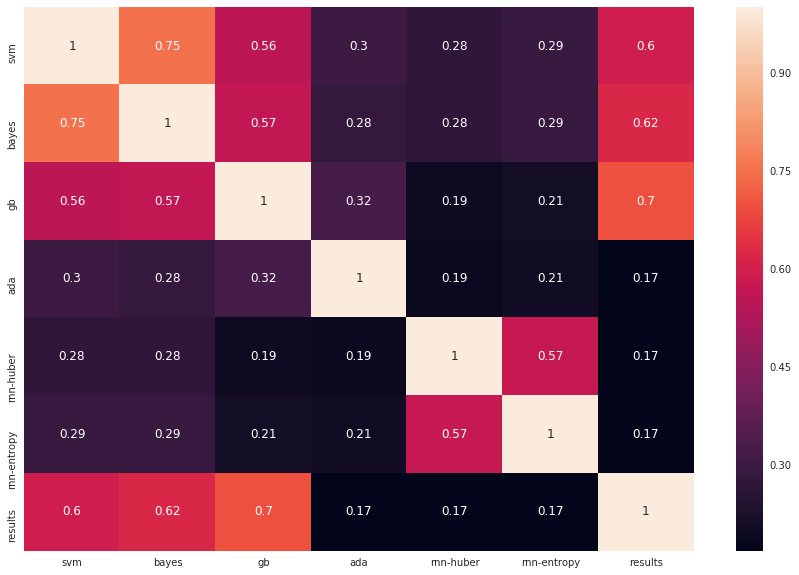

In [41]:
plt.figure(figsize=(15,10))
stack_train = np.vstack([mod_huber.predict(train_X),bayes_multinomial.predict(train_X),gb.predict(train_X), ada.predict(train_X),np.argmax(huber_prob_train, axis=1), np.argmax(entropy_prob_train, axis=1),train_Y]).T
corr_df = pd.DataFrame(stack_train, columns=['svm','bayes','gb','ada', 'rnn-huber','rnn-entropy','results'])
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

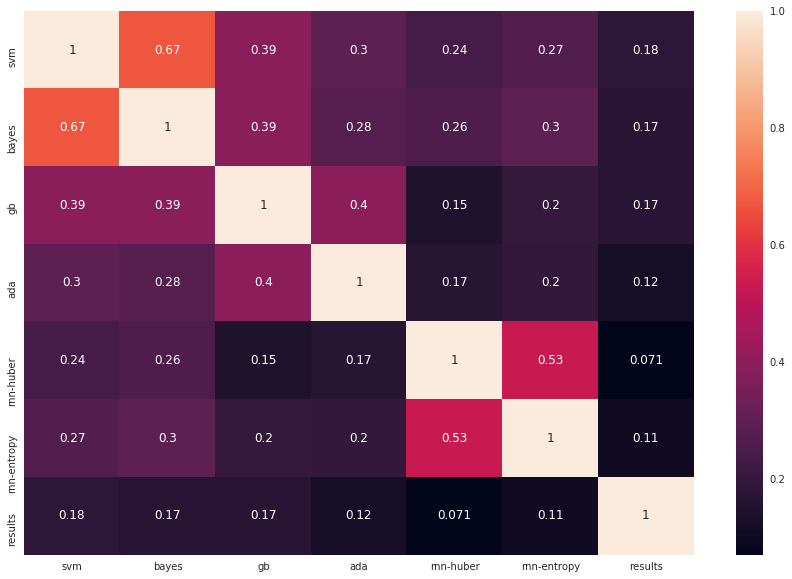

In [42]:
plt.figure(figsize=(15,10))
stack_test = np.vstack([mod_huber.predict(test_X),bayes_multinomial.predict(test_X),gb.predict(test_X), ada.predict(test_X),np.argmax(huber_prob, axis=1), np.argmax(entropy_prob, axis=1),test_Y]).T
corr_df = pd.DataFrame(stack_test, columns=['svm','bayes','gb','ada', 'rnn-huber','rnn-entropy','results'])
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

In [51]:
stack_train = np.hstack([mod_huber.predict_proba(train_X),bayes_multinomial.predict_proba(train_X),gb.predict_proba(train_X), ada.predict_proba(train_X),huber_prob_train, entropy_prob_train])
stack_test = np.hstack([mod_huber.predict_proba(test_X),bayes_multinomial.predict_proba(test_X),gb.predict_proba(test_X), ada.predict_proba(test_X),huber_prob, entropy_prob])

In [52]:
print(stack_train.shape)
print(stack_test.shape)

(10334, 12)
(2584, 12)


In [59]:
from bayes_opt import BayesianOptimization
def generate_stack(max_depth, gamma, min_child_weight, scale_pos_weight, reg_alpha, reg_lambda):
    global accbest
    param = {
        'max_depth' : int(np.around(max_depth)),
        'objective': 'binary:logistic',
        'learning_rate': 0.003333,
        'gamma' : gamma,
        'min_child_weight' : min_child_weight,
        'scale_pos_weight': scale_pos_weight,
        'reg_alpha' : reg_alpha,
        'reg_lambda':reg_lambda,
        'n_estimators': 300
    }
    clf = xgb.XGBClassifier(**param)
    clf.fit(stack_train,train_Y)
    predicted = clf.predict(stack_test)
    valid_acc = np.mean(predicted == test_Y)
    print("stop after 300 iteration with valid acc %f" % (valid_acc))
    if (valid_acc > accbest):
        costbest = valid_acc
    return valid_acc

In [60]:
accbest = 0.0
stack_bayesian = BayesianOptimization(generate_stack, {'max_depth': (2, 6.99),'gamma': (0.1, 5),'min_child_weight': (0, 5),'scale_pos_weight': (1, 5),'reg_alpha': (0, 10),'reg_lambda': (1, 10)})
stack_bayesian.maximize(init_points = 10, n_iter = 20, acq = 'ei', xi = 0.0)

Initialization
------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     gamma |   max_depth |   min_child_weight |   reg_alpha |   reg_lambda |   scale_pos_weight | 
stop after 300 iteration with valid acc 0.581269
    1 | 00m03s |    0.58127 |    1.9359 |      4.7718 |             0.1718 |      8.7385 |       2.8803 |             3.2769 | 
stop after 300 iteration with valid acc 0.591331
    2 | 00m02s |    0.59133 |    2.9037 |      5.4831 |             3.5124 |      8.5938 |       7.7208 |             1.0419 | 
stop after 300 iteration with valid acc 0.586687
    3 | 00m03s |    0.58669 |    1.3036 |      6.2033 |             3.5349 |      7.3203 |       7.1570 |             2.0266 | 
stop after 300 iteration with valid acc 0.585139
    4 | 00m02s |    0.58514 |    3.9706 |      3.9949 |             0.7985 |      6.4895 |       1.0203 |             4.2944 | 
stop after 300 iterati

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 6, 'warnflag': 2, 'funcalls': 60, 'grad': array([ -1.78689281e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   11 | 00m16s |    0.58901 |    4.0663 |      2.0991 |             2.6854 |      0.0489 |       1.0439 |             1.0507 | 
stop after 300 iteration with valid acc 0.590170


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 4, 'warnflag': 2, 'funcalls': 47, 'grad': array([  3.25331740e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   12 | 00m08s |    0.59017 |    4.1856 |      2.0923 |             0.1342 |      4.6701 |       9.6071 |             1.0049 | 
stop after 300 iteration with valid acc 0.590170


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 4, 'warnflag': 2, 'funcalls': 47, 'grad': array([  1.40612592e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   13 | 00m08s |    0.59017 |    0.1890 |      2.2737 |             4.9793 |      8.4555 |       7.7316 |             1.0029 | 
stop after 300 iteration with valid acc 0.590170


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 5, 'warnflag': 2, 'funcalls': 59, 'grad': array([ -1.91359698e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   14 | 00m08s |    0.59017 |    0.7780 |      2.1617 |             2.1297 |      3.2254 |       5.8038 |             1.0051 | 
stop after 300 iteration with valid acc 0.590944


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 4, 'warnflag': 2, 'funcalls': 49, 'grad': array([ -5.34537644e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 4, 'warnflag': 2, 'funcalls': 49, 'grad': array([-0.00010638]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   15 | 00m10s |    0.59094 |    4.8256 |      5.9923 |             4.9922 |      9.4213 |       9.6821 |             1.0115 | 
stop after 300 iteration with valid acc 0.590170


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 2, 'warnflag': 2, 'funcalls': 44, 'grad': array([  9.81929195e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   16 | 00m08s |    0.59017 |    4.8148 |      2.2251 |             0.4008 |      0.0410 |       6.3909 |             1.1895 | 
stop after 300 iteration with valid acc 0.596362
   17 | 00m06s |    0.59636 |    0.1791 |      2.0024 |             0.2643 |      0.0194 |       3.3835 |             1.6203 | 
stop after 300 iteration with valid acc 0.594040
   18 | 00m06s |    0.59404 |    4.8396 |      2.4078 |             4.0654 |      9.8856 |       1.2351 |             1.8578 | 
stop after 300 iteration with valid acc 0.583978


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 5, 'warnflag': 2, 'funcalls': 52, 'grad': array([  3.96146188e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   19 | 00m06s |    0.58398 |    0.5553 |      2.0832 |             4.2479 |      0.1144 |       1.1992 |             4.2451 | 
stop after 300 iteration with valid acc 0.594814
   20 | 00m06s |    0.59481 |    4.4482 |      2.5628 |             4.8709 |      9.9928 |       6.6121 |             1.1989 | 
stop after 300 iteration with valid acc 0.592492
   21 | 00m05s |    0.59249 |    0.1946 |      2.0007 |             0.1186 |      0.6922 |       6.8881 |             3.1486 | 
stop after 300 iteration with valid acc 0.589783


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 4, 'warnflag': 2, 'funcalls': 50, 'grad': array([  7.82220327e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   22 | 00m06s |    0.58978 |    3.8891 |      2.1190 |             3.6835 |      9.7017 |       9.7613 |             1.2261 | 
stop after 300 iteration with valid acc 0.589783
   23 | 00m07s |    0.58978 |    4.4468 |      4.8265 |             4.9951 |      9.9917 |       4.0380 |             1.0003 | 
stop after 300 iteration with valid acc 0.594040


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 5, 'warnflag': 2, 'funcalls': 54, 'grad': array([ 0.00032187]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   24 | 00m05s |    0.59404 |    4.9632 |      2.0857 |             1.4925 |      9.6434 |       2.1693 |             1.3204 | 
stop after 300 iteration with valid acc 0.590170
   25 | 00m06s |    0.59017 |    0.4968 |      2.0292 |             0.2447 |      0.9228 |       2.1165 |             1.0002 | 
stop after 300 iteration with valid acc 0.589009


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 6, 'warnflag': 2, 'funcalls': 52, 'grad': array([  2.48285646e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   26 | 00m08s |    0.58901 |    0.4305 |      2.1241 |             1.4067 |      0.5735 |       5.5566 |             1.0468 | 
stop after 300 iteration with valid acc 0.584752


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 5, 'warnflag': 2, 'funcalls': 54, 'grad': array([  5.79937951e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   27 | 00m09s |    0.58475 |    0.6039 |      2.1835 |             0.2808 |      0.0955 |       2.9897 |             4.1577 | 
stop after 300 iteration with valid acc 0.594040
   28 | 00m09s |    0.59404 |    4.8538 |      2.0279 |             4.8653 |      6.1488 |       4.4801 |             1.3616 | 
stop after 300 iteration with valid acc 0.590557
   29 | 00m09s |    0.59056 |    0.2184 |      2.4664 |             4.7846 |      9.0458 |       1.0078 |             1.1453 | 
stop after 300 iteration with valid acc 0.594040
   30 | 00m09s |    0.59404 |    4.9786 |      2.2079 |             4.5975 |      4.7948 |       1.2136 |             1.3788 | 


In [61]:
print('Maximum accuracy value: %f' % stack_bayesian.res['max']['max_val'])
print('Best parameters: ', stack_bayesian.res['max']['max_params'])

Maximum accuracy value: 0.596362
Best parameters:  {'max_depth': 2.0024276362131621, 'gamma': 0.17908412443987298, 'reg_lambda': 3.3834524892572224, 'reg_alpha': 0.019426115025547031, 'min_child_weight': 0.26425441256794802, 'scale_pos_weight': 1.6203111511728578}


In [62]:
import xgboost as xgb
params_xgd = {
    'max_depth': 2,
    'objective': 'binary:logistic',
    'learning_rate': 0.003333,
    'gamma' : 0.17908412443987298,
    'min_child_weight' : 0.26425441256794802,
    'scale_pos_weight': 1.6203111511728578,
    'reg_alpha' : 0.019426115025547031,
    'reg_lambda': 3.3834524892572224,
    'nthread': -1,
    'silent': False,
    'n_estimators': 10000
    }
clf = xgb.XGBClassifier(**params_xgd)
clf.fit(stack_train,train_Y, eval_set=[(stack_test,test_Y)], 
        eval_metric='logloss', early_stopping_rounds=100, verbose=True)

[0]	validation_0-logloss:0.692681
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.692223
[2]	validation_0-logloss:0.691773
[3]	validation_0-logloss:0.69133
[4]	validation_0-logloss:0.690886
[5]	validation_0-logloss:0.690458
[6]	validation_0-logloss:0.690029
[7]	validation_0-logloss:0.689609
[8]	validation_0-logloss:0.689193
[9]	validation_0-logloss:0.68876
[10]	validation_0-logloss:0.688367
[11]	validation_0-logloss:0.687965
[12]	validation_0-logloss:0.687559
[13]	validation_0-logloss:0.687179
[14]	validation_0-logloss:0.686786
[15]	validation_0-logloss:0.68641
[16]	validation_0-logloss:0.68603
[17]	validation_0-logloss:0.685676
[18]	validation_0-logloss:0.685309
[19]	validation_0-logloss:0.684959
[20]	validation_0-logloss:0.684604
[21]	validation_0-logloss:0.684266
[22]	validation_0-logloss:0.683916
[23]	validation_0-logloss:0.683607
[24]	validation_0-logloss:0.683269
[25]	validation_0-logloss:0.682963
[26]	validation_0-logloss:0.682636


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.17908412443987298,
       learning_rate=0.003333, max_delta_step=0, max_depth=2,
       min_child_weight=0.264254412567948, missing=None,
       n_estimators=10000, n_jobs=1, nthread=-1,
       objective='binary:logistic', random_state=0,
       reg_alpha=0.01942611502554703, reg_lambda=3.3834524892572224,
       scale_pos_weight=1.6203111511728578, seed=None, silent=False,
       subsample=1)

In [63]:
predicted = clf.predict(stack_test)
print('accuracy validation set: ', np.mean(predicted == test_Y))
print(metrics.classification_report(test_Y, predicted, target_names = label))

accuracy validation set:  0.593653250774
             precision    recall  f1-score   support

   negative       0.59      0.59      0.59      1281
   positive       0.60      0.60      0.60      1303

avg / total       0.59      0.59      0.59      2584



In [67]:
clf.predict_proba(stack_test)

array([[ 0.41565824,  0.58434176],
       [ 0.70962721,  0.29037279],
       [ 0.27590144,  0.72409856],
       ..., 
       [ 0.62264705,  0.37735292],
       [ 0.27590144,  0.72409856],
       [ 0.61838031,  0.38161966]], dtype=float32)

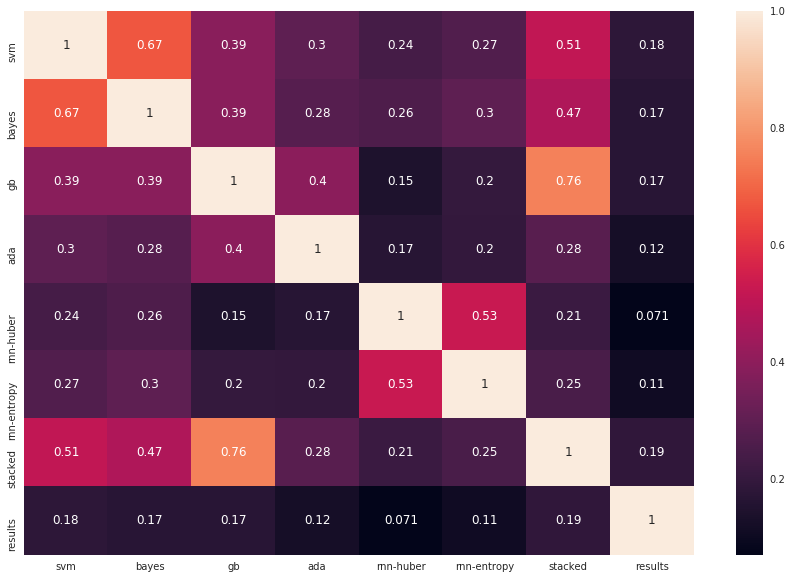

In [64]:
plt.figure(figsize=(15,10))
stacked = np.vstack([mod_huber.predict(test_X),bayes_multinomial.predict(test_X),gb.predict(test_X), ada.predict(test_X),np.argmax(huber_prob, axis=1), np.argmax(entropy_prob, axis=1),clf.predict(stack_test), test_Y]).T
corr_df = pd.DataFrame(stacked, columns=['svm','bayes','gb','ada','rnn-huber','rnn-entropy','stacked','results'])
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

In [66]:
with open('svm-model.p', 'wb') as fopen:
    pickle.dump(mod_huber, fopen)
with open('bayes-model.p', 'wb') as fopen:
    pickle.dump(bayes_multinomial, fopen)
with open('gb-model.p', 'wb') as fopen:
    pickle.dump(gb, fopen)
with open('ada-model.p', 'wb') as fopen:
    pickle.dump(ada, fopen)
with open('stack-model.p', 'wb') as fopen:
    pickle.dump(clf, fopen)
with open('tfidf.p', 'wb') as fopen:
    pickle.dump(tfidf, fopen)